In [99]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import warnings
warnings.simplefilter("ignore", UserWarning)

import numpy as np
import cv2
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.misc import derivative

from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from alibi.explainers import ALE
from alibi.explainers.ale import plot_ale
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.models import Sequential, Model

tf.random.set_seed(7324)
np.random.seed(7324)

In [203]:
df = pd.read_csv("../datasets/landslides_processed.csv")

df

,Lat,Long,Rain Yesterday,Rain Today,Landslide,Forest Percentage,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,4.63,-74.11,-0.688526,-0.752257,1,0.932852,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.01,-74.49,-0.471202,0.310720,1,0.932852,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.11,-75.19,-0.204486,1.220277,1,0.932852,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.40,-76.58,0.309189,1.779162,1,0.932852,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.63,-74.11,-0.253878,1.033982,1,0.932852,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,4.80,-75.80,-0.431688,0.146342,1,-2.385851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1004,6.00,-75.05,-0.688526,-0.752257,1,-2.385851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1005,6.25,-75.58,-0.688526,-0.752257,1,-2.385851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1006,6.18,-75.61,-0.688526,-0.752257,1,-2.385851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


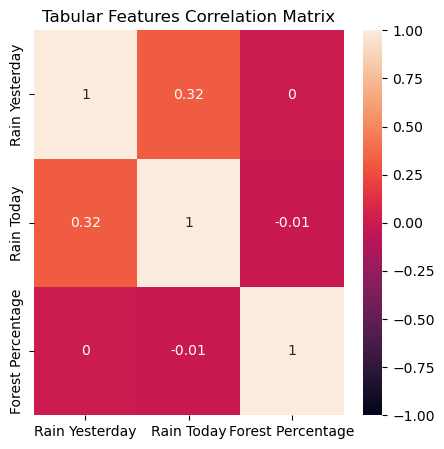

In [221]:
features = [ x for x in df.columns if x not in ["Lat", "Long", "Landslide"] ]
numeric_features = [ x for x in features if not x.startswith("Month_") ]

plt.subplots(figsize=(5, 5))
sns.heatmap(np.round(df[numeric_features].corr(), 2), annot=True, vmin = -1, vmax = 1)

plt.title("Tabular Features Correlation Matrix")
 
plt.show()

In [205]:
coords = df[["Lat", "Long"]]
X = df.copy().drop(["Lat", "Long", "Landslide"], axis = 1).to_numpy()
y = df["Landslide"].to_numpy()

X_train, X_test, y_train, y_test, coords_train, coords_test = train_test_split(
    X, y, coords, test_size = 0.1, stratify = y, random_state = 1326
)

In [206]:
# Source: https://www.kaggle.com/code/arsenyinfo/f-beta-score-for-keras/script

class BinaryFBeta:
    def __init__(self, beta: float = 1.0):
        self.beta = beta
        
    def fbeta_score(self, y_true, y_pred):
        # just in case of hipster activation at the final layer
        y_pred = K.clip(y_pred, 0, 1)

        # shifting the prediction threshold from .5 if needed
        y_pred_bin = K.round(y_pred)

        tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
        fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
        fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        beta_squared = self.beta ** 2
        return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [214]:
model1 = Sequential()
model1.add(Dense(10, activation = "relu"))
model1.add(Dense(5, activation = "relu"))
model1.add(Dense(1, activation = "sigmoid"))

fbeta = BinaryFBeta(beta = 4)
model1.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=["acc", fbeta.fbeta_score]
)

input_shape = [None, X.shape[1]]
model1.build(input_shape)

model1.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 10)                160       
                                                                 
 dense_58 (Dense)            (None, 5)                 55        
                                                                 
 dense_59 (Dense)            (None, 1)                 6         
                                                                 
Total params: 221 (884.00 Byte)
Trainable params: 221 (884.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [215]:
history1 = []
hist1 = model1.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=50, batch_size=128
)
history1.append(hist1)

Epoch 1/50
8/8 [==============================] - 9s 561ms/step - loss: 0.7168 - acc: 0.4840 - fbeta_score: 0.4406 - val_loss: 0.6913 - val_acc: 0.5248 - val_fbeta_score: 0.5387
Epoch 2/50
8/8 [==============================] - 0s 23ms/step - loss: 0.6984 - acc: 0.5083 - fbeta_score: 0.5061 - val_loss: 0.6809 - val_acc: 0.5545 - val_fbeta_score: 0.5593
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.6859 - acc: 0.5424 - fbeta_score: 0.5171 - val_loss: 0.6711 - val_acc: 0.5743 - val_fbeta_score: 0.5793
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.6742 - acc: 0.5722 - fbeta_score: 0.5412 - val_loss: 0.6618 - val_acc: 0.5842 - val_fbeta_score: 0.5986
Epoch 5/50
8/8 [==============================] - 0s 19ms/step - loss: 0.6634 - acc: 0.6020 - fbeta_score: 0.5700 - val_loss: 0.6542 - val_acc: 0.6040 - val_fbeta_score: 0.6185
Epoch 6/50
8/8 [==============================] - 0s 15ms/step - loss: 0.6544 - acc: 0.6196 - fbeta_score: 0.5864 

In [216]:
def plot_loss(history):
    # combine all the history from training together
    combined = dict()
    for key in ['fbeta_score','val_fbeta_score','loss','val_loss']:
        combined[key] = np.hstack([x.history[key] for x in history])
        
    # summarize history for accuracy
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(combined['fbeta_score'])
    plt.plot(combined['val_fbeta_score'])
    plt.title('Model F-Beta Score')
    plt.ylabel('F-Beta Score Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # summarize history for loss
    plt.subplot(122)
    plt.plot(combined['loss'])
    plt.plot(combined['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


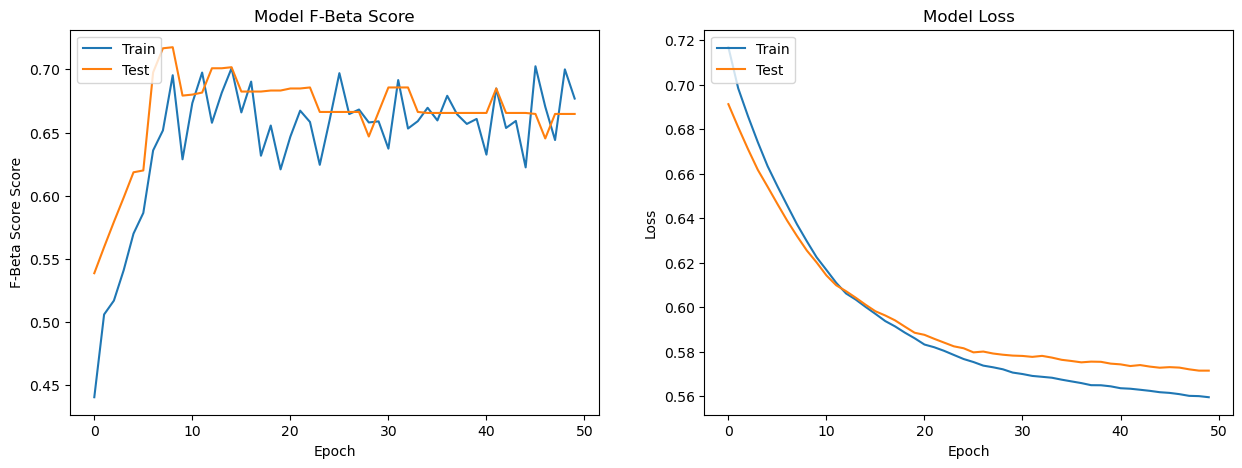

In [217]:
plot_loss(history1)

In [218]:
def compare_models(y, yhat):
    categories = ["No Landslide", "Landslide"]
    num_models = len(yhat)
    fbeta = BinaryFBeta(beta = 4)
    if num_models > 2:
        num_rows = 2
        plt.figure(figsize = (15, 10))
    else:
        num_rows = 1
        plt.figure(figsize = (15, 5))
    num_cols = num_models // num_rows
    if num_rows * num_cols < num_models:
        num_cols += 1
    for i in range(num_models):
        acc = mt.accuracy_score(y, yhat[i])
        fbeta = fbeta.fbeta_score(y, yhat[i])
        plt.subplot(num_rows, num_cols, i+1)
        cm = mt.confusion_matrix(y, yhat[i])
        sns.heatmap(cm, annot=True, fmt='.1f', xticklabels=categories, yticklabels=categories)
        plt.title(f'Model {i+1}: Accuracy = {acc:.4f}, F-Beta = {fbeta:.4f}')
        plt.xlabel("Predicted Class")
        plt.ylabel("Actual Class")

4/4 [==============================] - 0s 17ms/step


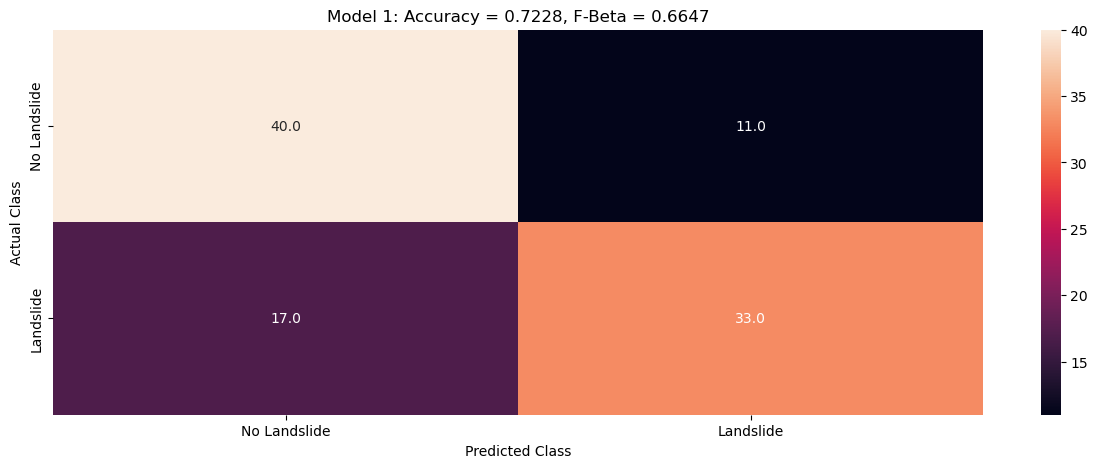

In [219]:
start = time.time()
model1_proba = model1.predict(X_test)
model1_pred = np.round(list(map(lambda x: x[0], model1_proba)))
model1_pred_time = time.time() - start

compare_models(y_test, [model1_pred])

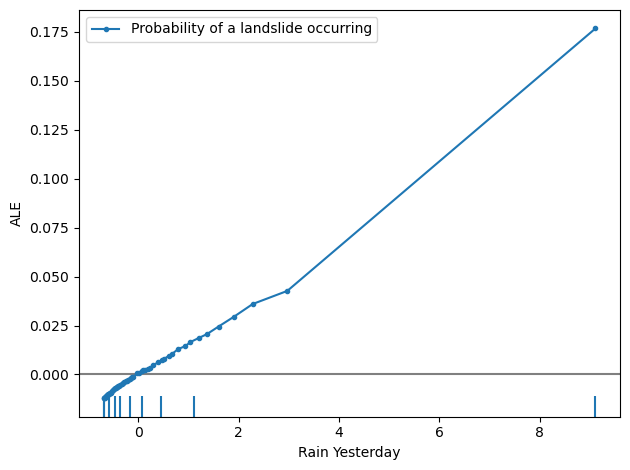

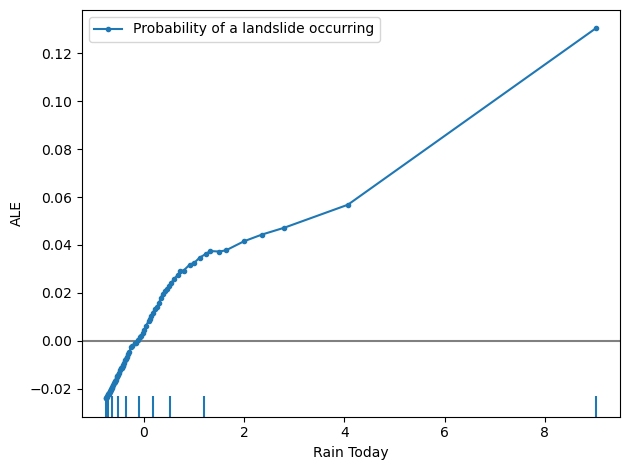

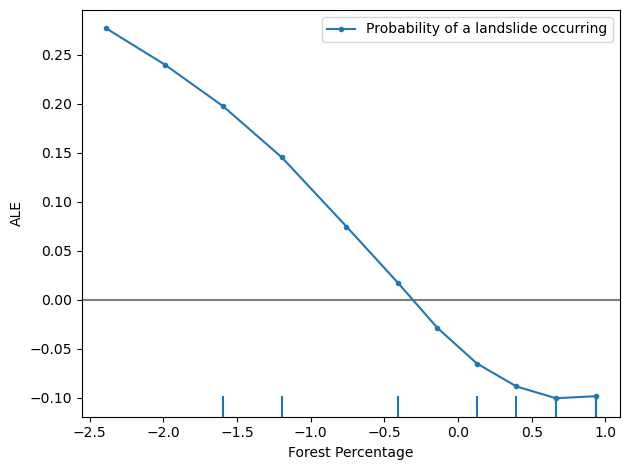

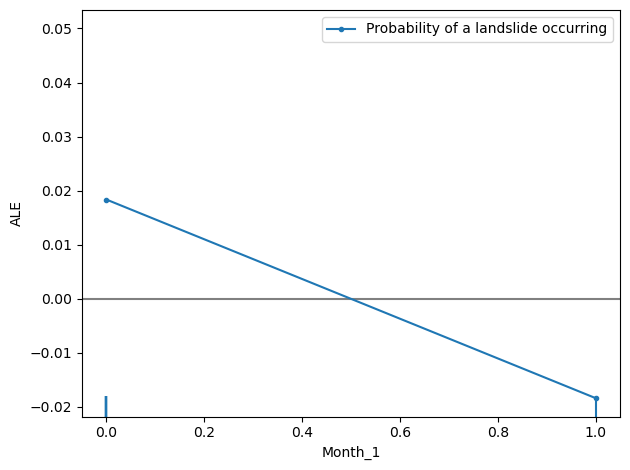

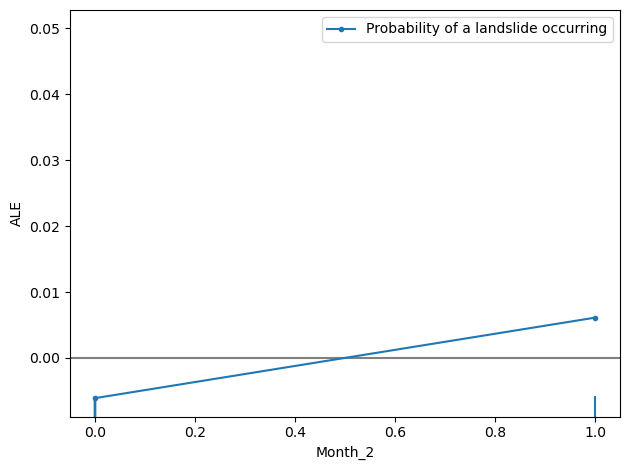

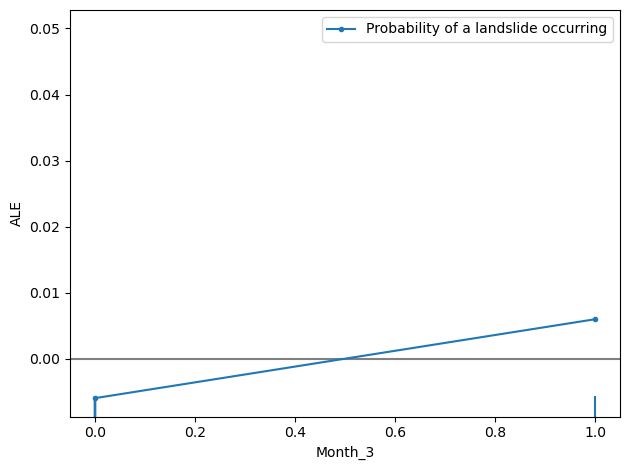

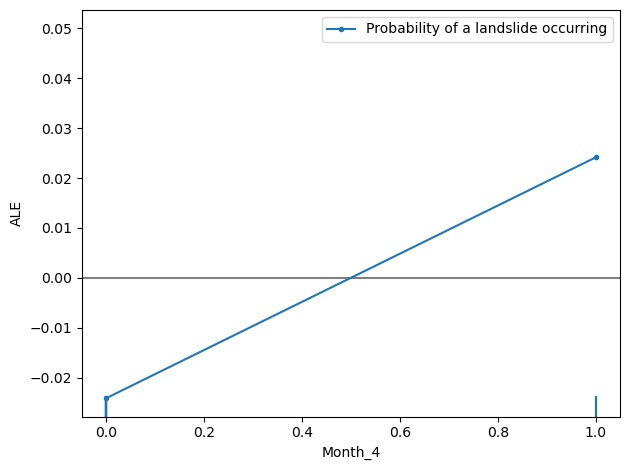

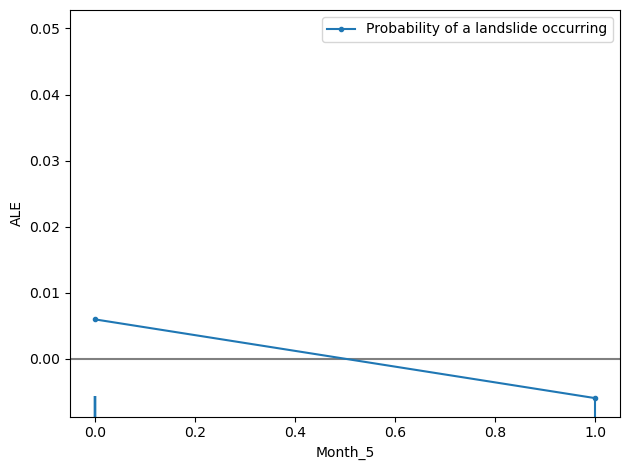

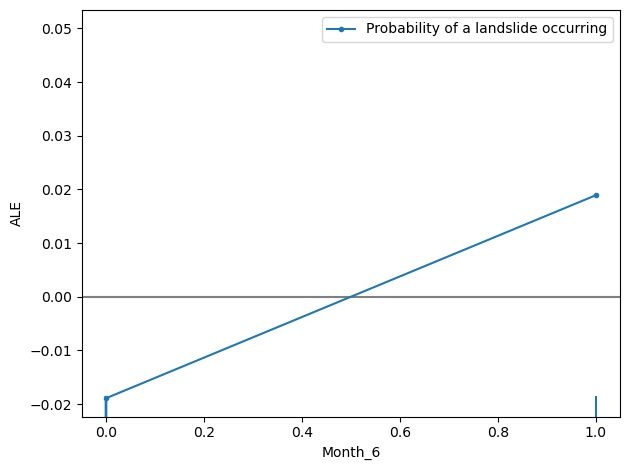

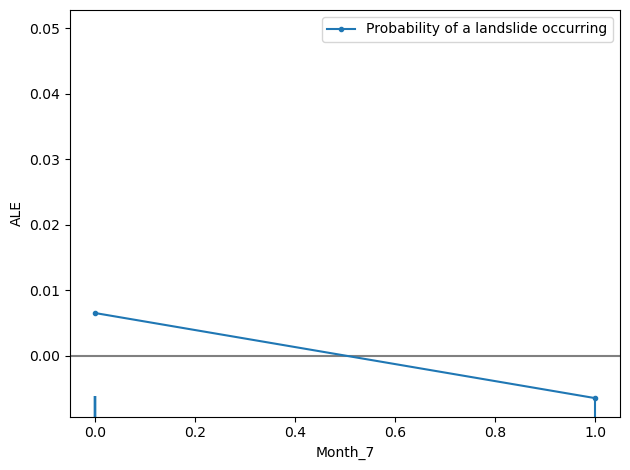

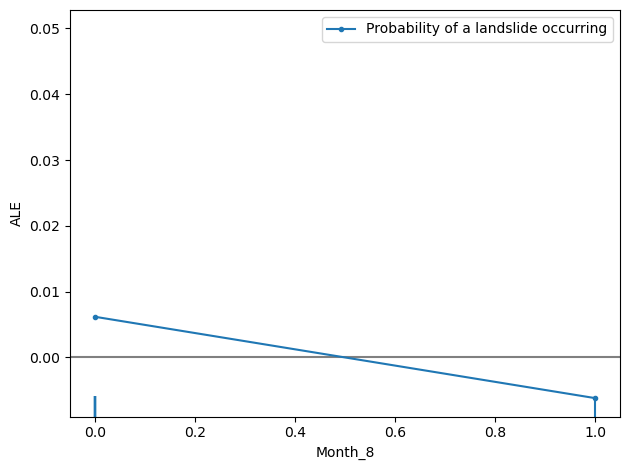

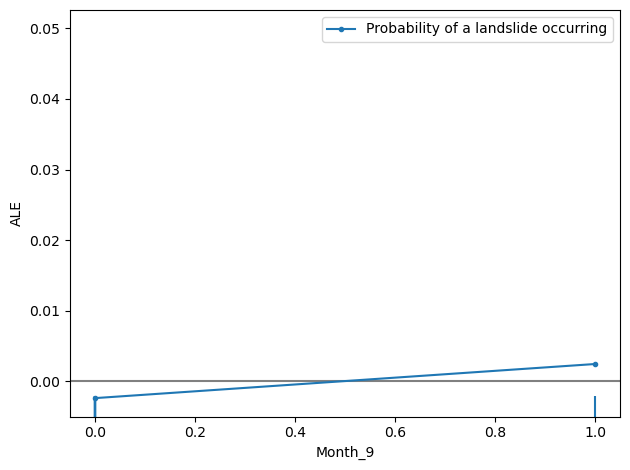

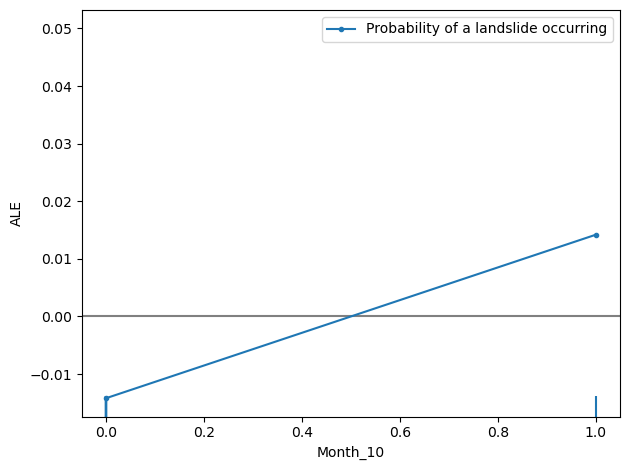

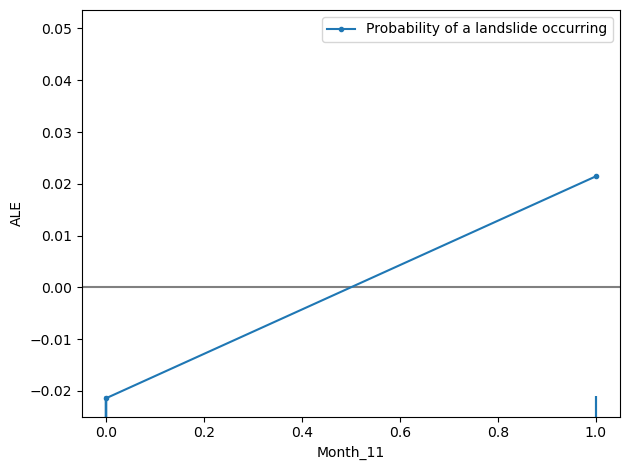

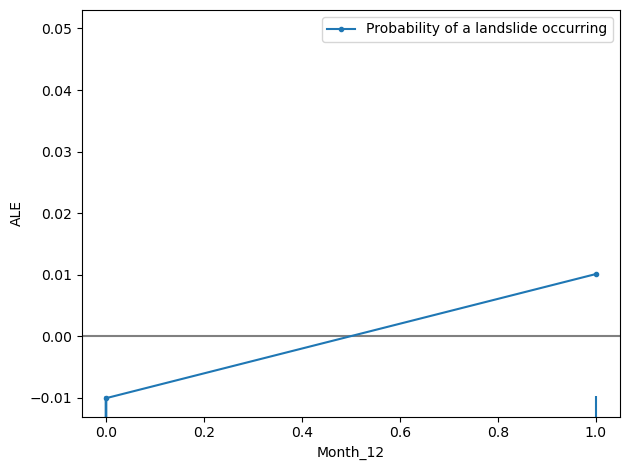

In [220]:
# https://docs.seldon.io/projects/alibi/en/latest/examples/overview.html

predict_fn = lambda x: model1(x).numpy()[:, 0]

ale = ALE(predict_fn, feature_names=features)
exp = ale.explain(X_train)

for feature in features:
    plot_ale(exp, features=[feature], line_kw={'label': 'Probability of a landslide occurring'})
    plt.show()

In [222]:
def get_maps(coords, map_type):
    imgs = []
    for i, row in coords.iterrows():
        if row["Lat"] < 0.5:
            lat = 0.5
        elif row["Lat"] > 10:
            lat = 10
        else:
            lat = row["Lat"]
            
        if row["Long"] < -80:
            long = -80
        elif row["Long"] > -70.5:
            long = -70.5
        else:
            long = row["Long"]
    
        img = cv2.imread("../datasets/maps/{}/{}_{}.jpg".format(
            map_type,
            np.ceil(lat * 2) / 2,
            np.floor(long * 2) / 2
        ))
        img = cv2.resize(img, (500, 500))
        if len(img.shape) == 2:
            tf_img = tf.convert_to_tensor(img.reshape((*img.shape, 1)))
            imgs.append(tf.image.grayscale_to_rgb(tf_img))
        else:
            imgs.append(img)
    return np.array(imgs)

In [12]:
img_last_train = get_maps(coords_train, "last")
img_last_test = get_maps(coords_test, "last")

print(img_last_train.shape)
print(img_last_test.shape)

(907, 500, 500, 3)
(101, 500, 500, 3)


In [59]:
def create_model(input_shape, num_filter_layers, kernel_size, pool_size, dropout = None, neurons = [], head = True):
    cnn = Sequential()

    for num_filters in num_filter_layers:
        cnn.add( 
            Conv2D(
                filters=num_filters, 
                kernel_size=kernel_size, 
                padding='same'
            ) 
        )
        cnn.add(Activation('relu'))
        cnn.add(MaxPooling2D(pool_size=pool_size))

    # add one layer on flattened output
    cnn.add(Flatten())
    if dropout != None:
        cnn.add(Dropout(dropout))
    for n in neurons:
        cnn.add(Dense(n, activation = "relu"))
        
    if head:
        cnn.add(Dense(1, activation = "sigmoid"))

    # Let's train the model 
    cnn.compile(
        loss='binary_crossentropy',
        optimizer='rmsprop',
        metrics=["acc", fbeta.fbeta_score]
    )
    cnn.build(input_shape)
    
    return cnn

In [92]:
h = img_last_train.shape[1]
w = img_last_train.shape[2]
channels = img_last_train.shape[3]

model2 = create_model([None, h, w, channels], [32, 32], (10, 10), (10, 10), 0.5, [256, 64, 5])

model2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 500, 500, 32)      9632      
                                                                 
 activation_34 (Activation)  (None, 500, 500, 32)      0         
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 50, 50, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 50, 50, 32)        102432    
                                                                 
 activation_35 (Activation)  (None, 50, 50, 32)        0         
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 5, 5, 32)          0         
 ng2D)                                               

In [93]:
history2 = []
hist2 = model2.fit(
    img_last_train, y_train, 
    validation_data=(img_last_test, y_test),
    epochs=15, batch_size=64
)
history2.append(hist2)

Epoch 1/15
15/15 [==============================] - 36s 2s/step - loss: 79.0673 - acc: 0.5149 - fbeta_score: 0.4713 - val_loss: 1.1205 - val_acc: 0.4851 - val_fbeta_score: 0.7340
Epoch 2/15
15/15 [==============================] - 17s 1s/step - loss: 2.0196 - acc: 0.4906 - fbeta_score: 0.5636 - val_loss: 0.8350 - val_acc: 0.4257 - val_fbeta_score: 0.6195
Epoch 3/15
15/15 [==============================] - 18s 1s/step - loss: 15.4383 - acc: 0.5039 - fbeta_score: 0.4475 - val_loss: 19.8927 - val_acc: 0.4950 - val_fbeta_score: 0.9456
Epoch 4/15
15/15 [==============================] - 18s 1s/step - loss: 292.7955 - acc: 0.4884 - fbeta_score: 0.3148 - val_loss: 523.2806 - val_acc: 0.5050 - val_fbeta_score: 4.3121e-09
Epoch 5/15
15/15 [==============================] - 17s 1s/step - loss: 491.6125 - acc: 0.4994 - fbeta_score: 5.4769e-09 - val_loss: 448.6655 - val_acc: 0.5050 - val_fbeta_score: 4.3121e-09
Epoch 6/15
15/15 [==============================] - 17s 1s/step - loss: 414.8578 - acc:

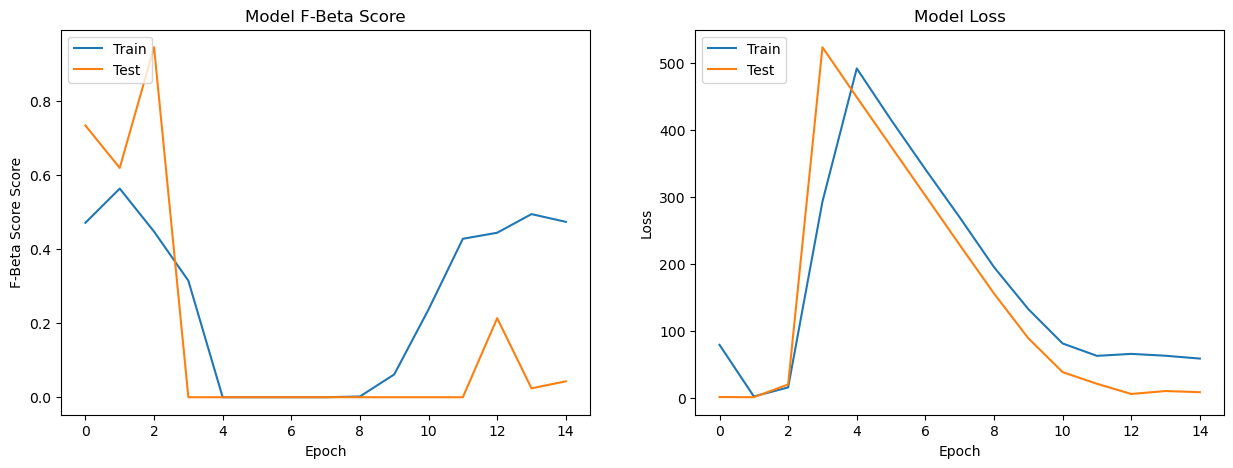

In [94]:
plot_loss(history2)

4/4 [==============================] - 1s 178ms/step


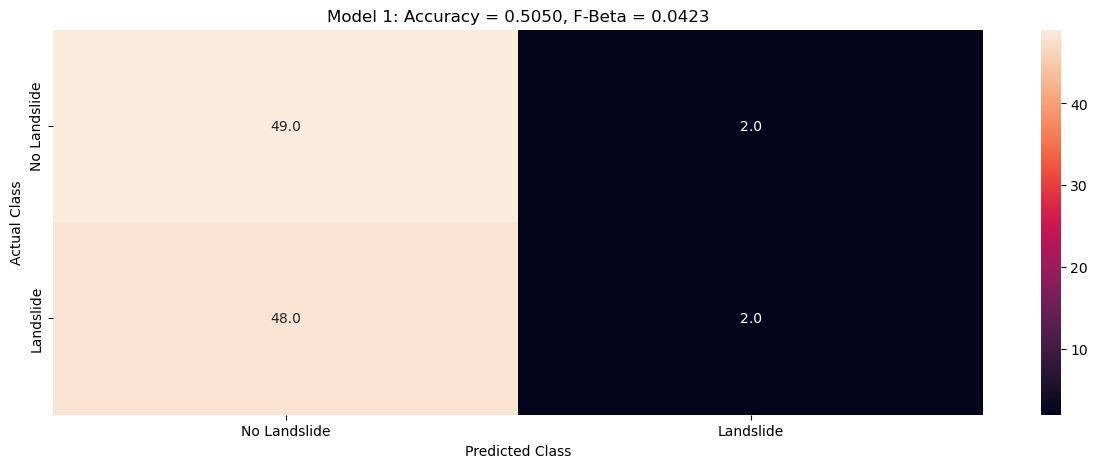

In [95]:
model2_proba = model2.predict(img_last_test)
model2_pred = np.round(list(map(lambda x: x[0], model2_proba)))

compare_models(y_test, [model2_pred])

In [223]:
img_lossyear_train = get_maps(coords_train, "lossyear")
img_lossyear_test = get_maps(coords_test, "lossyear")

print(img_lossyear_train.shape)
print(img_lossyear_test.shape)

[ WARN:0@2705.553] global loadsave.cpp:248 findDecoder imread_('../datasets/maps/lossyear/7.5_-75.5.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [98]:
h = img_lossyear_train.shape[1]
w = img_lossyear_train.shape[2]
channels = img_lossyear_train.shape[3]

model3 = create_model([None, h, w, channels], [32, 32], (10, 10), (10, 10), 0.5, [256, 64])

model3.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 500, 500, 32)      9632      
                                                                 
 activation_38 (Activation)  (None, 500, 500, 32)      0         
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 50, 50, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 50, 50, 32)        102432    
                                                                 
 activation_39 (Activation)  (None, 50, 50, 32)        0         
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 5, 5, 32)          0         
 ng2D)                                               

In [99]:
history3 = []
hist3 = model3.fit(
    img_lossyear_train, y_train, 
    validation_data=(img_lossyear_test, y_test),
    epochs=15, batch_size=64
)
history3.append(hist3)

Epoch 1/15
15/15 [==============================] - 35s 2s/step - loss: 17.5025 - acc: 0.5094 - fbeta_score: 0.3920 - val_loss: 1.3347 - val_acc: 0.5050 - val_fbeta_score: 4.3121e-09
Epoch 2/15
15/15 [==============================] - 15s 977ms/step - loss: 1.7945 - acc: 0.4807 - fbeta_score: 0.4161 - val_loss: 0.7472 - val_acc: 0.4257 - val_fbeta_score: 0.4634
Epoch 3/15
15/15 [==============================] - 16s 1s/step - loss: 1.3376 - acc: 0.5160 - fbeta_score: 0.4680 - val_loss: 0.7636 - val_acc: 0.5149 - val_fbeta_score: 0.8882
Epoch 4/15
15/15 [==============================] - 16s 1s/step - loss: 1.4966 - acc: 0.4807 - fbeta_score: 0.4040 - val_loss: 0.8918 - val_acc: 0.5050 - val_fbeta_score: 4.3121e-09
Epoch 5/15
15/15 [==============================] - 15s 1s/step - loss: 1.2095 - acc: 0.4983 - fbeta_score: 0.4371 - val_loss: 1.6036 - val_acc: 0.5050 - val_fbeta_score: 4.3121e-09
Epoch 6/15
15/15 [==============================] - 16s 1s/step - loss: 1.1294 - acc: 0.4895 -

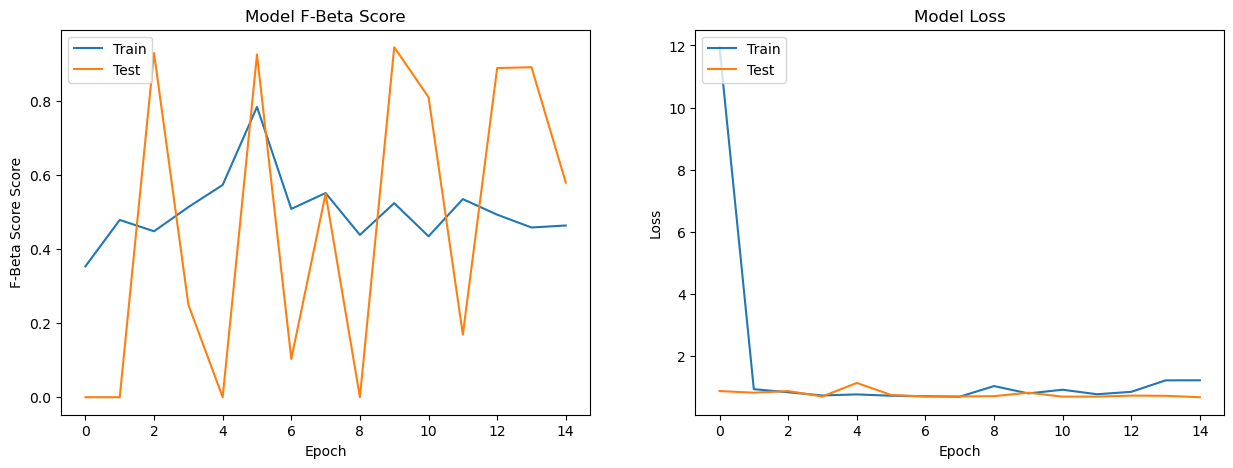

In [ ]:
plot_loss(history3)

4/4 [==============================] - 1s 162ms/step


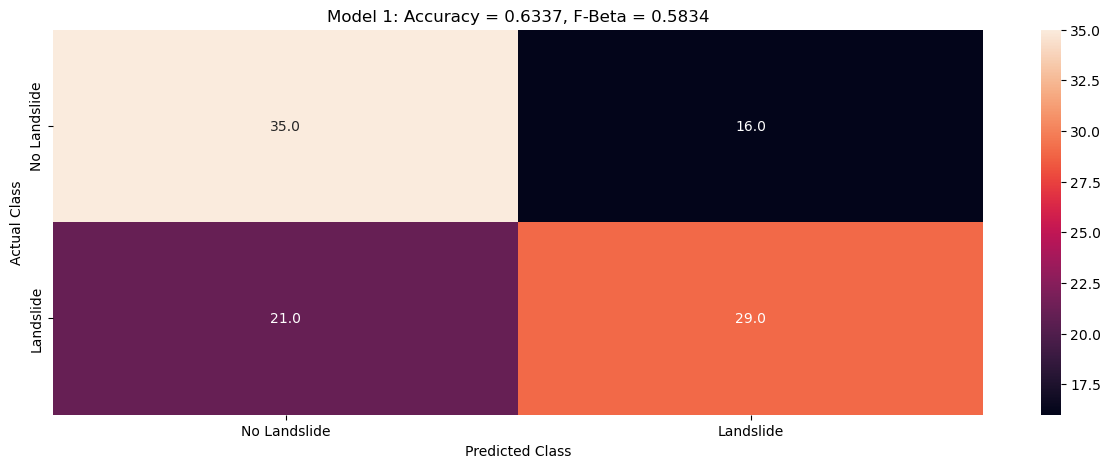

In [ ]:
model3_proba = model3.predict(img_lossyear_test)
model3_pred = np.round(list(map(lambda x: x[0], model3_proba)))

compare_models(y_test, [model3_pred])

In [90]:
model1.layers[0].get_weights()

[array([[ 1.1610922 ,  0.45224681,  0.20744902,  0.5477659 ,  0.7678615 ,
          0.22064732, -0.02032451,  0.02274878,  0.96602815,  0.08245999],
        [ 0.45770925,  1.0119426 ,  0.27410316,  0.6435346 ,  0.02455542,
          0.52312684,  0.34920612,  0.21994498,  0.80330294,  0.25544545],
        [-0.26949513, -0.15851814, -0.939816  ,  0.5303232 ,  0.35679883,
         -0.33482063, -1.1791997 , -0.9195697 , -0.16999137, -1.1222486 ],
        [-0.34070563,  0.00752475,  0.23079798,  0.12903045,  0.32507786,
          0.05432856,  0.12247352,  0.07476062, -0.2472099 ,  0.33322692],
        [ 0.33345166,  0.00535159,  0.04972619,  0.43260995, -0.01505738,
          0.615033  ,  0.64651304, -0.4125907 , -0.5072773 ,  0.2507059 ],
        [-0.3794162 , -0.37723815, -0.13555664, -0.35386288, -0.54964685,
         -0.38396248,  0.11933444, -0.0164492 , -0.01368125,  0.26799175],
        [-0.22361362, -0.29126897,  0.08515332,  0.10201089, -0.20510252,
         -0.20296086, -0.016121 

In [56]:
X_train.shape

(907, 13)

In [91]:
# table_branch = Sequential()
# table_branch.add(Dense(10, activation = "relu"))
# table_branch.add(Dropout(0.3))
# table_branch.add(Dense(5, activation = "relu"))

# table_branch.build((None, X_train.shape[1]))
# table_branch.compile(
#     loss='binary_crossentropy',
#     optimizer='rmsprop',
#     metrics=["acc", fbeta.fbeta_score]
# )

# history_table = []
# hist_table = table_branch.fit(
#     X_train, y_train, 
#     validation_data=(X_test, y_test),
#     epochs=75, batch_size=64
# )
# history_table.append(hist_table)

# plot_loss(history_table)

In [ ]:
map_branch = create_model([None, h, w, channels], [32, 32], (10, 10), (10, 10), 0.5, [256, 64, 5], head = False)

merged_branch = Concatenate()([ table_branch.output, map_branch.output ])
merged_branch = Dense(5, activation = "relu")(merged_branch)
merged_branch = Dense(1, activation = "sigmoid")(merged_branch)

model4 = Model(inputs = [table_branch.input, map_branch.input], outputs = merged_branch)
model4.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=["acc", fbeta.fbeta_score]
)

model4.summary()


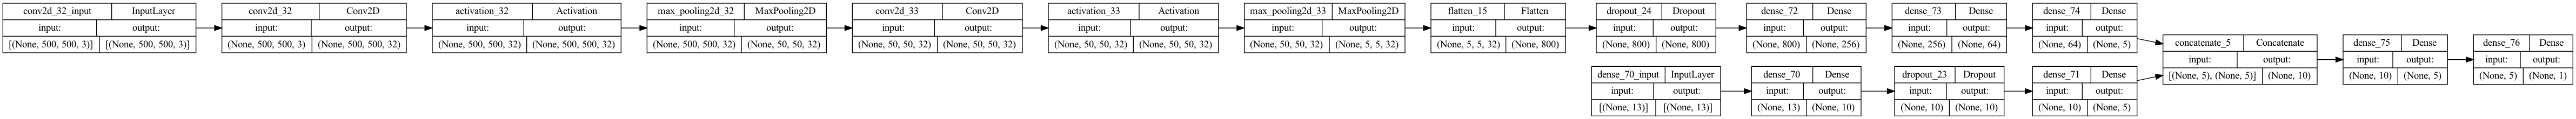

In [68]:
plot_model(
    model4, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [69]:
history4 = []
hist4 = model4.fit(
    [X_train, img_lossyear_train], y_train, 
    validation_data=([X_test, img_lossyear_test], y_test),
    epochs=15, batch_size=64
)
history4.append(hist4)

Epoch 1/15
15/15 [==============================] - 40s 2s/step - loss: 2054.6160 - acc: 0.4950 - fbeta_score: 0.1544 - val_loss: 278.6007 - val_acc: 0.4752 - val_fbeta_score: 0.6801
Epoch 2/15
15/15 [==============================] - 16s 948ms/step - loss: 1169.8765 - acc: 0.5193 - fbeta_score: 0.5149 - val_loss: 677.1447 - val_acc: 0.5347 - val_fbeta_score: 0.1094
Epoch 3/15
15/15 [==============================] - 16s 1s/step - loss: 1282.9753 - acc: 0.5237 - fbeta_score: 0.7787 - val_loss: 2079.6501 - val_acc: 0.4950 - val_fbeta_score: 0.9456
Epoch 4/15
15/15 [==============================] - 15s 1s/step - loss: 3650.2834 - acc: 0.5006 - fbeta_score: 0.9432 - val_loss: 2697.1924 - val_acc: 0.4950 - val_fbeta_score: 0.9456
Epoch 5/15
15/15 [==============================] - 16s 1s/step - loss: 2219.9202 - acc: 0.5006 - fbeta_score: 0.9387 - val_loss: 2130.6550 - val_acc: 0.4950 - val_fbeta_score: 0.9456
Epoch 6/15
15/15 [==============================] - 15s 1s/step - loss: 1640.38

KeyboardInterrupt: 

In [ ]:
table_branch = Sequential()
for i, layer in enumerate(model1.layers):
    if i < len(model1.layers) - 1:
        layer.trainable = False
        table_branch.add(layer)       
table_branch.build((None, X_train.shape[1]))

map_branch = Sequential()
for i, layer in enumerate(model3.layers):
    if i < len(model3.layers) - 1:
        layer.trainable = False
        map_branch.add(layer)
map_branch.build((None, h, w, channels))

merged_branch = Concatenate()([ table_branch.output, map_branch.output ])
merged_branch = Dense(5, activation = "relu")(merged_branch)
merged_branch = Dense(1, activation = "sigmoid")(merged_branch)

model4 = Model(inputs = [table_branch.input, map_branch.input], outputs = merged_branch)
model4.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=["acc", fbeta.fbeta_score]
)

model4.summary()